In [1]:
import sys
from pathlib import Path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
from calculator_core import *
from calculator_core.ATP_DEC import *

In [2]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_log_error
import seaborn as sns
sns.set_theme(style="whitegrid")

In [3]:
df = pd.read_csv(project_root / "results" / "NO_non_Kyoto" / "2023" / "LHR-ICN" / "results_CF.csv")
df_tim = pd.read_csv(project_root / "results" / "TIM" / "2023" / "LHR-ICN" / "results.csv")

In [4]:
common_flights = pd.merge(df, df_tim, on='flight_id', how='inner')
df = df[df['flight_id'].isin(common_flights['flight_id'])]
df_tim = df_tim[df_tim['flight_id'].isin(common_flights['flight_id'])]

In [5]:
df['actual_total_flight'] = ( df['actual_footprint_first'] * 8) + ( df['actual_footprint_business'] * 48) + ( df['actual_footprint_premium_economy'] * 35) + (df['actual_footprint_economy'] * 146)
df['post_total_flight'] = ( df['post_footprint_first_7D'] * 8) + ( df['post_footprint_business_7D'] * 48) + ( df['post_footprint_premium_economy_7D'] * 35) + (df['post_footprint_economy_7D'] * 146)

In [6]:
df_tim['TIM'] = df_tim['TIM'].apply(json.loads)
df_tim['TIM_actual_distance'] = df_tim['TIM_actual_distance'].apply(json.loads)

In [7]:
df_tim['TIM_first'] = df_tim['TIM'].apply(lambda x: x[0])
df_tim['TIM_business'] = df_tim['TIM'].apply(lambda x: x[1])
df_tim['TIM_premium_economy'] = df_tim['TIM'].apply(lambda x: x[2])
df_tim['TIM_economy'] = df_tim['TIM'].apply(lambda x: x[3])

# multiplied by number of passengers in each class
df_tim['TIM_total_flight'] = (df_tim['TIM_first'] * 8) + (df_tim['TIM_business'] * 48) + (df_tim['TIM_premium_economy'] * 35) + (df_tim['TIM_economy'] * 146)

In [8]:
df_tim['TIM_actual_first'] = df_tim['TIM_actual_distance'].apply(lambda x: x[0])
df_tim['TIM_actual_business'] = df_tim['TIM_actual_distance'].apply(lambda x: x[1])
df_tim['TIM_actual_premium_economy'] = df_tim['TIM_actual_distance'].apply(lambda x: x[2])
df_tim['TIM_actual_economy'] = df_tim['TIM_actual_distance'].apply(lambda x: x[3])

# multiplied by number of passengers in each class
df_tim['TIM_actual_total_flight'] = (df_tim['TIM_actual_first'] * 8) + (df_tim['TIM_actual_business'] * 48) + (df_tim['TIM_actual_premium_economy'] * 35) + (df_tim['TIM_actual_economy'] * 146) 

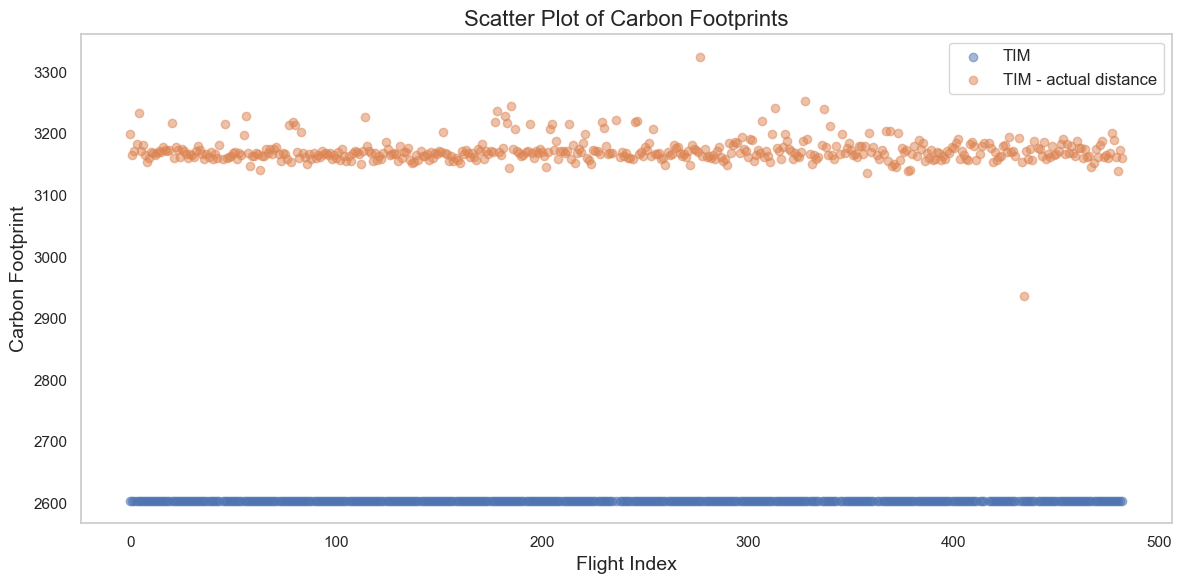

In [9]:
plt.figure(figsize=(12, 6))
plt.scatter(df_tim.index, df_tim['TIM_first'], label='TIM', alpha=0.5)
plt.scatter(df_tim.index, df_tim['TIM_actual_first'], label='TIM - actual distance', alpha=0.5)

plt.title('Scatter Plot of Carbon Footprints', fontsize=16)
plt.xlabel('Flight Index', fontsize=14)
plt.ylabel('Carbon Footprint', fontsize=14)
#plt.ylim([7500, 9500])
plt.legend(fontsize=12)
plt.tight_layout()
plt.grid()
plt.show()

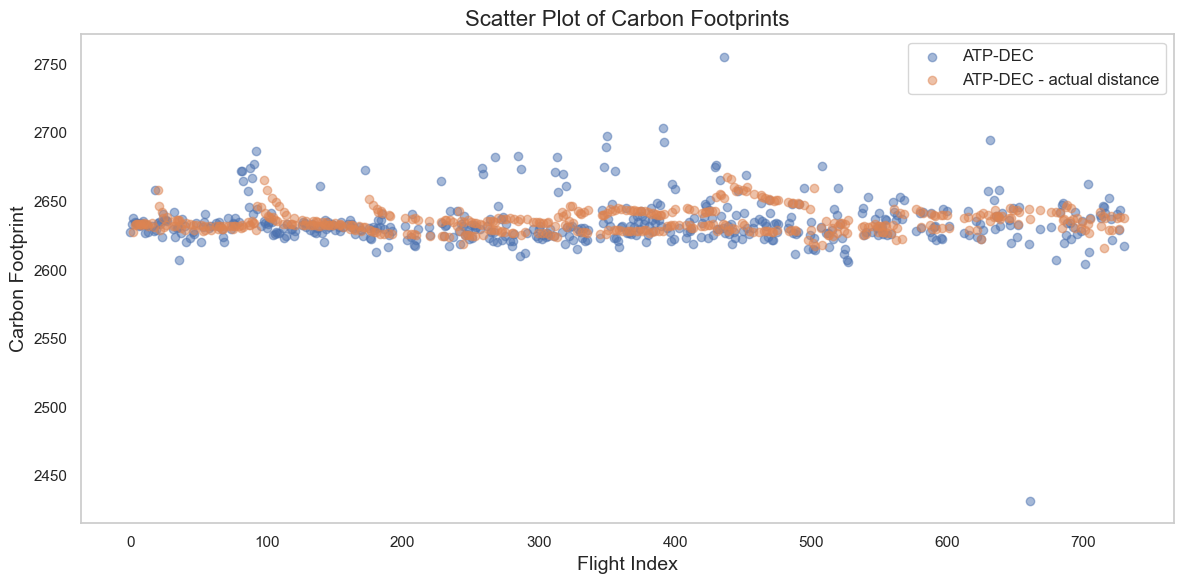

In [10]:
plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['actual_footprint_first'], label='ATP-DEC', alpha=0.5)
plt.scatter(df.index, df['post_footprint_first_30D'], label='ATP-DEC - actual distance', alpha=0.5)

plt.title('Scatter Plot of Carbon Footprints', fontsize=16)
plt.xlabel('Flight Index', fontsize=14)
plt.ylabel('Carbon Footprint', fontsize=14)
#plt.ylim([7500, 9500])
plt.legend(fontsize=12)
plt.tight_layout()
plt.grid()
plt.show()

In [11]:
df_tim.index = pd.to_datetime(df_tim['date'], format='%Y%m%d')
df.index = pd.to_datetime(df['date'])

df_tim_daily = df_tim.groupby(df_tim.index.date).first()
df_daily = df.groupby(df.index.date).first()

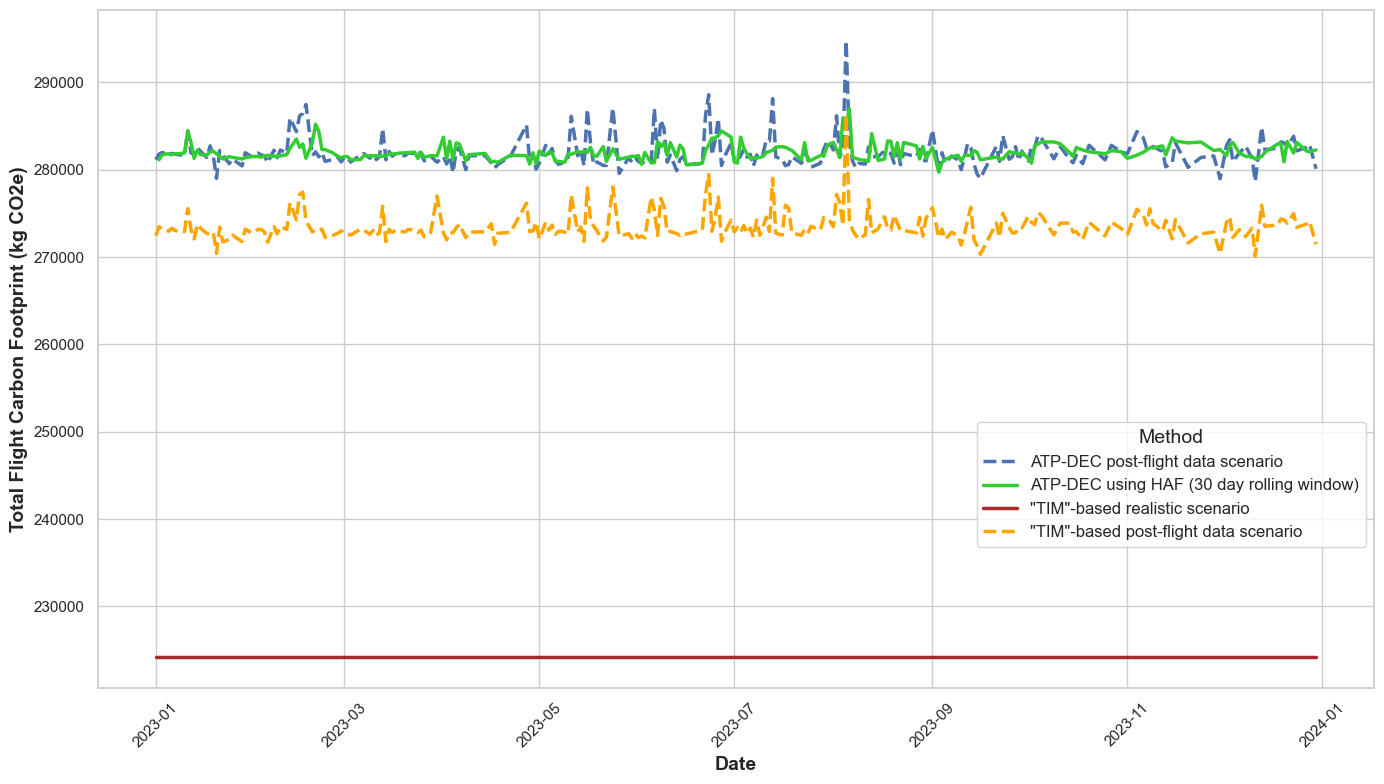

In [12]:
plt.figure(figsize=(14, 8))

sns.lineplot(data=df_daily, x=df_daily.index, y='actual_total_flight', label='ATP-DEC post-flight data scenario', linewidth=2.5, linestyle='--')
sns.lineplot(data=df_daily, x=df_daily.index, y='post_total_flight', label='ATP-DEC using HAF (30 day rolling window)', linewidth=2.5, color='limegreen')
sns.lineplot(data=df_tim_daily, x=df_tim_daily.index, y='TIM_total_flight', label='"TIM"-based realistic scenario', linewidth=2.5, color='brown')
sns.lineplot(data=df_tim_daily, x=df_tim_daily.index, y='TIM_actual_total_flight', label='"TIM"-based post-flight data scenario', linewidth=2.5, linestyle='--', color='orange')

#plt.title('Carbon Footprint (without Non-Kyoto) Method Comparison for LHR-ICN Flights in 2023', fontsize=18, weight='bold')
plt.xlabel('Date', fontsize=14, weight='bold')
plt.ylabel('Total Flight Carbon Footprint (kg CO2e)', fontsize=14, weight='bold')

plt.legend(title='Method', fontsize=12, title_fontsize=14, loc='right', bbox_to_anchor=(1, 0.3), frameon=True)

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

In [13]:
# Total emissions difference between TIM realistic and TIM actual

ttl_carbon = (df_tim['TIM_actual_total_flight'] - df_tim['TIM_total_flight']).sum()
ttl_carbon/1000

23150.520271930334

In [14]:
# Total emissions difference between ATP-DEC realistic and ATP-DEC actual

ttl_carbon = (df['actual_total_flight'] - df['post_total_flight']).sum()
ttl_carbon/1000

-44.741646199698415

In [15]:
# RMSLE for difference

df_1 = df_daily.dropna()
df_TIM_1 = df_tim_daily.dropna()

print(root_mean_squared_log_error(df_1['actual_footprint_first'], df_1['post_footprint_first_30D']))
print(root_mean_squared_log_error(df_TIM_1['TIM_actual_first'], df_TIM_1['TIM_first']))

0.006215530457967524
0.1986644734103062
